In [43]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random forest models modified. changed criterion to absolute error

In [44]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)

def get_data(features_path, labels_path=None, tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = preprocess_data(sj_features, sj_labels, tminus)
        iq_f, iq_l = preprocess_data(iq_features, iq_labels, tminus)
        return sj_f, sj_l, iq_f, iq_l

    return preprocess_data(sj_features, None, tminus), preprocess_data(iq_features, None, tminus)


In [45]:
tminus = 104
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',tminus=tminus)

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [46]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [47]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,655.0,0.085308,0.085051,-0.290200,0.042304,0.082313,0.120275,0.446267
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
ndvi_sw,655.0,0.168472,0.055406,-0.063457,0.134221,0.169529,0.203043,0.381420
precipitation_amt_mm,655.0,34.314218,41.118100,0.000000,0.925000,21.530000,50.610000,287.550000
...,...,...,...,...,...,...,...,...
station_avg_temp_c_104,655.0,27.108995,1.272241,22.842857,26.200000,27.328571,28.035714,30.071429
station_diur_temp_rng_c_104,655.0,6.948929,0.781756,4.528571,6.507143,7.028571,7.314286,9.914286
station_max_temp_c_104,655.0,28.928264,7.764522,-3.101640,29.400000,31.700000,32.800000,35.600000
station_min_temp_c_104,655.0,22.421309,1.451369,17.800000,21.108204,22.323348,23.900000,25.600000


In [48]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,286.0,0.266801,0.082939,0.090057,0.201750,0.264027,0.323425,0.488400
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_se,286.0,0.246971,0.075359,0.029880,0.192386,0.244057,0.299146,0.473400
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
precipitation_amt_mm,286.0,66.289900,35.693121,0.000000,40.715000,63.235000,88.872500,173.450000
...,...,...,...,...,...,...,...,...
station_avg_temp_c_104,286.0,27.525439,0.758059,25.075000,27.131250,27.459837,28.000000,30.800000
station_diur_temp_rng_c_104,286.0,10.406017,1.478260,6.700000,9.403584,10.415315,11.495000,15.800000
station_max_temp_c_104,286.0,33.603663,1.761547,27.356346,33.000000,33.800000,34.500000,42.200000
station_min_temp_c_104,286.0,21.015617,1.405521,14.700000,20.200000,21.000000,22.014707,23.700000


In [49]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

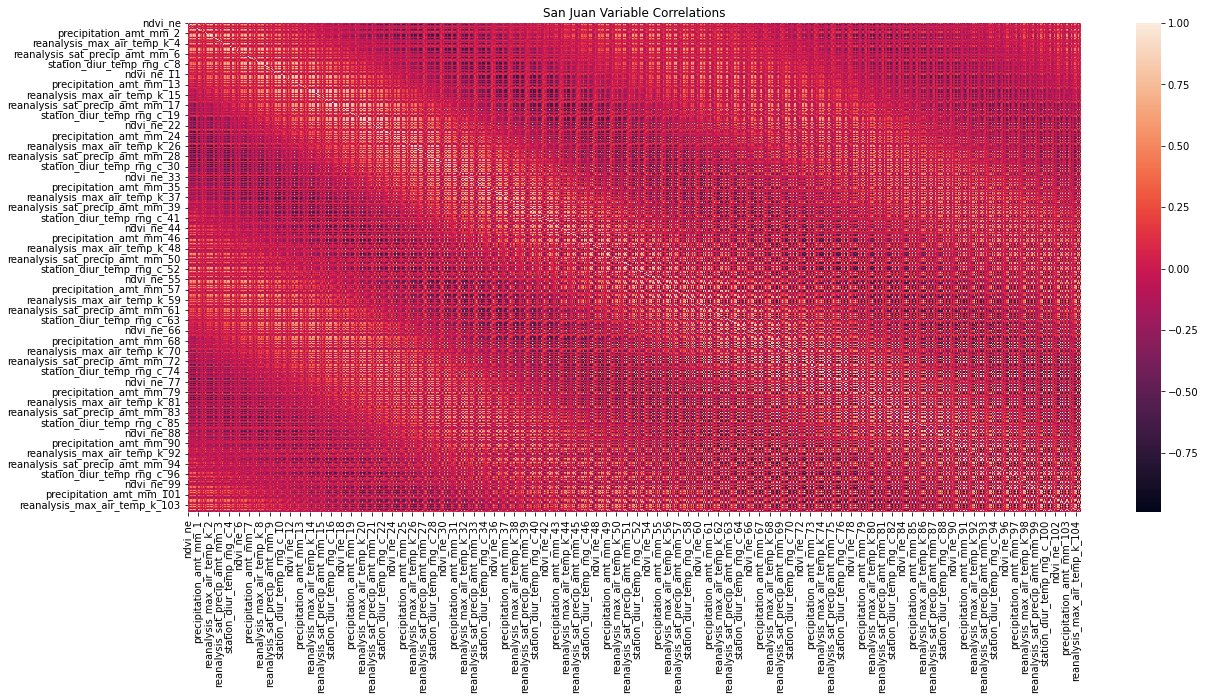

In [50]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [51]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=50,
                                criterion='absolute_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

22.808473282442748
16.992188612099643


In [52]:
sj_rf.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:ylabel='cols'>

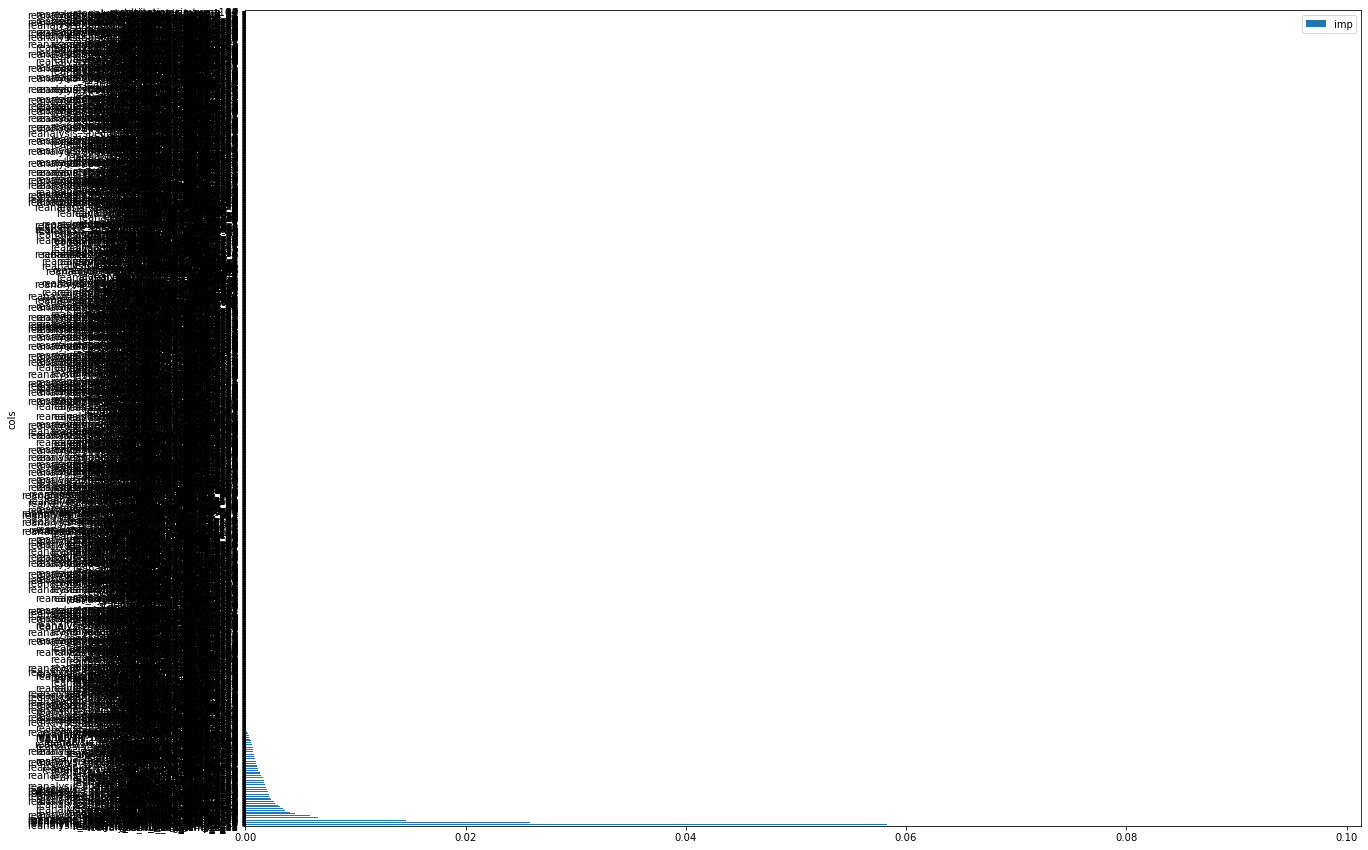

In [53]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [54]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=50, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

5.179241865220434
7.236668230249697


In [55]:
iq_rf.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:ylabel='cols'>

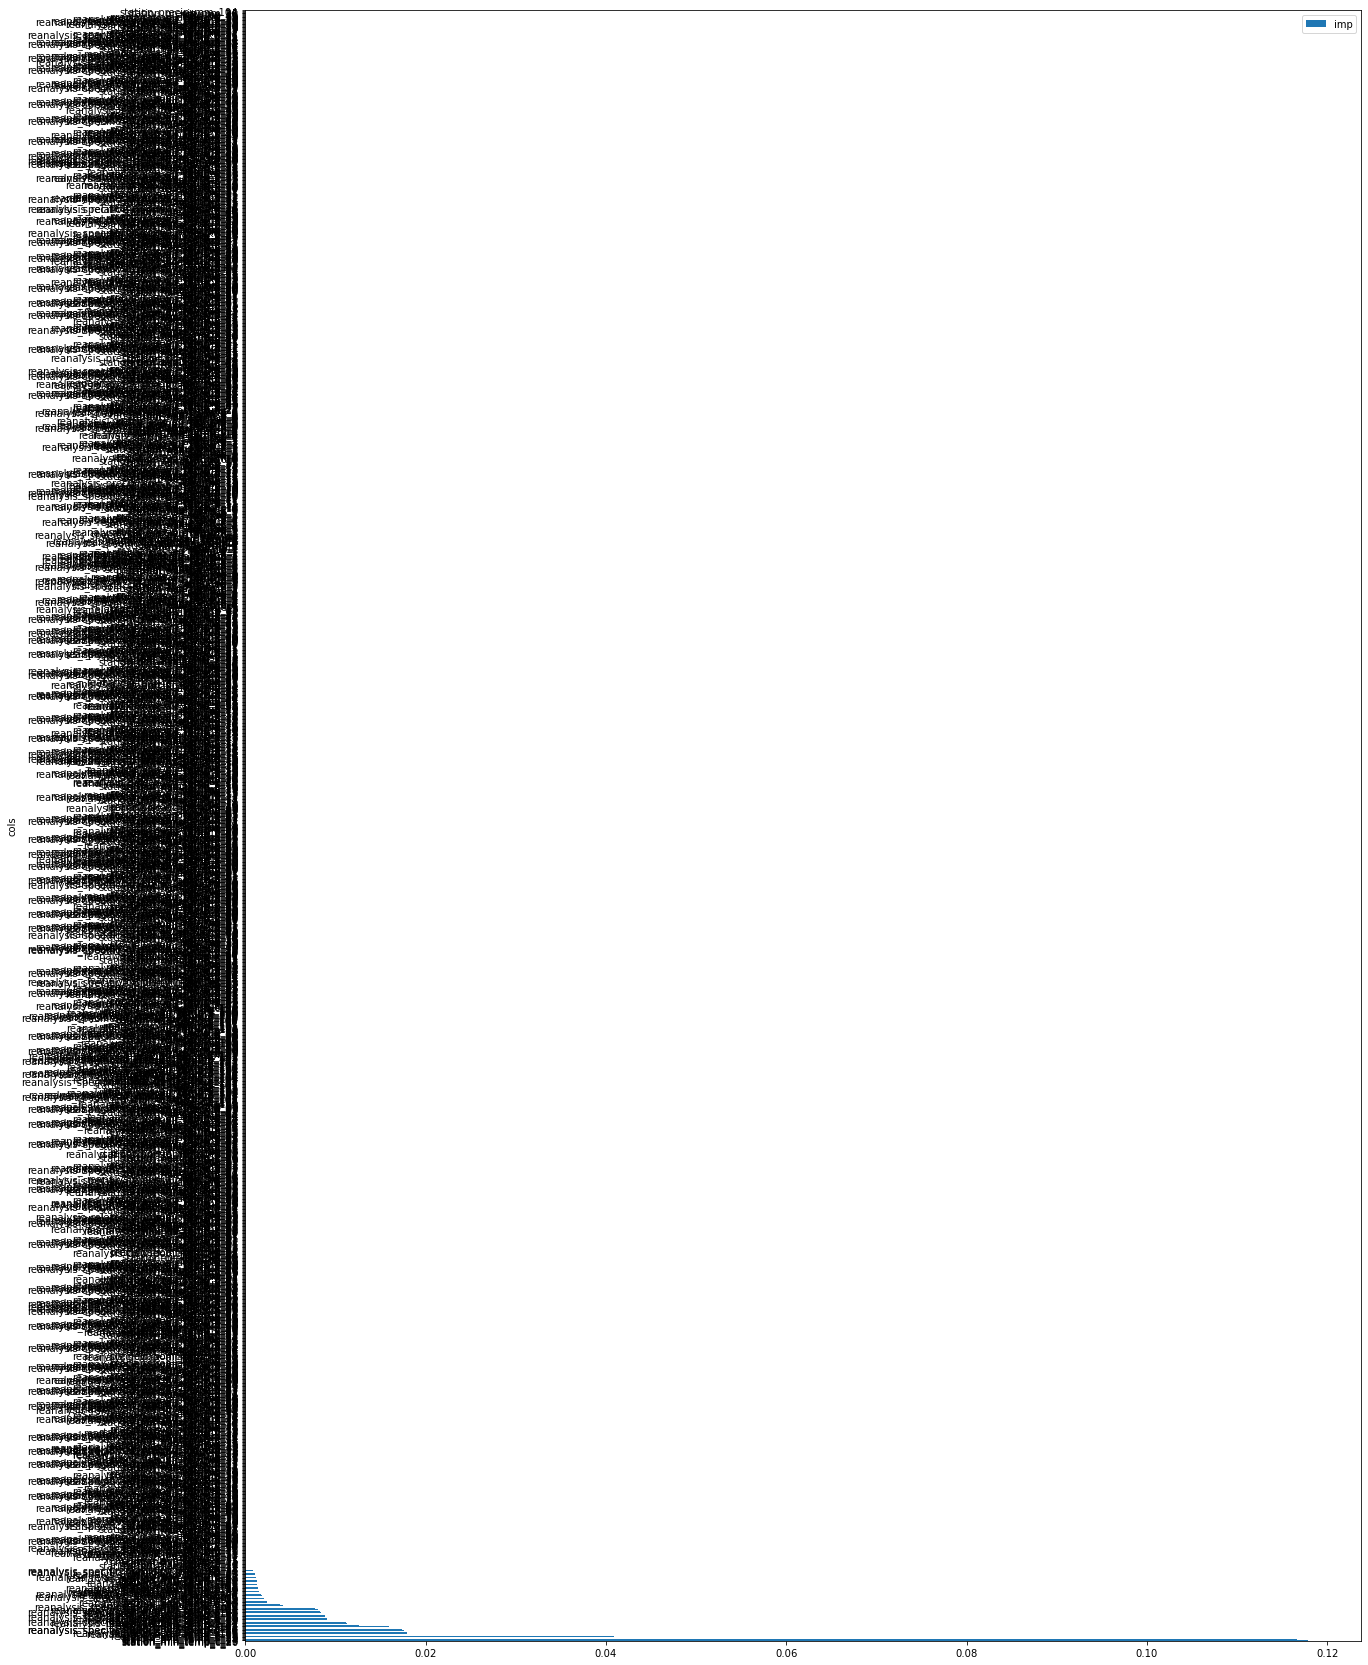

In [56]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

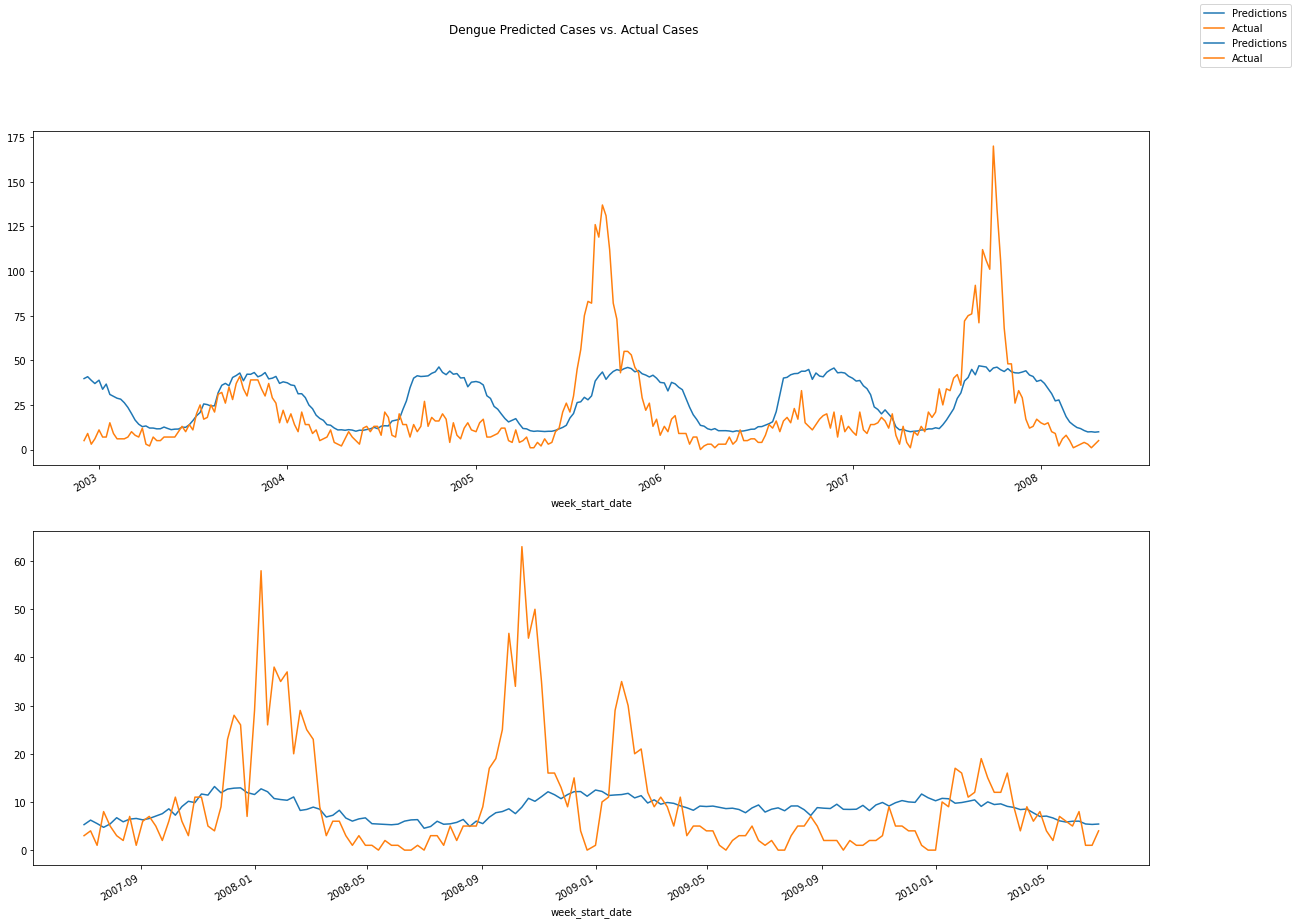

In [57]:
plt.rcParams["figure.figsize"] = (20,15)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [58]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [59]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',tminus=tminus) 

In [60]:
sj_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_104,reanalysis_relative_humidity_percent_104,reanalysis_sat_precip_amt_mm_104,reanalysis_specific_humidity_g_per_kg_104,reanalysis_tdtr_k_104,station_avg_temp_c_104,station_diur_temp_rng_c_104,station_max_temp_c_104,station_min_temp_c_104,station_precip_mm_104
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,...,401.064957,273.710944,6961.997767,11.578424,2.992959,35.825424,6.026225,11.240184,23.574928,3844.355111
2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,...,397.467465,271.853416,6896.082467,11.628768,2.991461,35.757439,6.026540,11.439498,23.577627,3808.246523
2008-05-13,-0.001500,0.061357,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,...,393.869973,269.995888,6830.167166,11.679112,2.989963,35.689454,6.026855,11.638811,23.580326,3772.137935
2008-05-20,0.072478,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,...,390.272480,268.138359,6764.251865,11.729456,2.988465,35.621468,6.027169,11.838125,23.583025,3736.029348
2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,...,386.674988,266.280831,6698.336565,11.779800,2.986968,35.553483,6.027484,12.037439,23.585725,3699.920760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,...,16.100000,74.022857,0.000000,13.698571,2.628571,25.100000,6.542857,29.400000,20.600000,11.600000
2013-04-02,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,...,13.160000,80.141429,15.130000,15.345714,2.528571,25.714286,7.142857,31.100000,20.600000,12.100000
2013-04-09,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,...,6.900000,80.085714,1.900000,16.092857,2.742857,27.000000,7.800000,32.800000,21.700000,4.600000


In [61]:
iq_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_104,reanalysis_relative_humidity_percent_104,reanalysis_sat_precip_amt_mm_104,reanalysis_specific_humidity_g_per_kg_104,reanalysis_tdtr_k_104,station_avg_temp_c_104,station_diur_temp_rng_c_104,station_max_temp_c_104,station_min_temp_c_104,station_precip_mm_104
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,...,2593.283228,920.145265,5941.521357,13.224852,44.877340,28.641748,-6.895831,25.195797,98.893424,223.590864
2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,...,2568.742144,912.207855,5885.334768,13.253734,44.540439,28.633829,-6.726541,25.282216,98.145168,221.553737
2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,...,2544.201060,904.270446,5829.148179,13.282617,44.203537,28.625909,-6.557251,25.368634,97.396911,219.516610
2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,...,2519.659976,896.333037,5772.961589,13.311500,43.866636,28.617989,-6.387960,25.455052,96.648654,217.479484
2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,...,2495.118892,888.395628,5716.775000,13.340382,43.529735,28.610069,-6.218670,25.541470,95.900397,215.442357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,...,35.900000,92.128571,105.130000,17.545714,9.542857,27.575626,9.400424,33.200000,20.855776,38.100000
2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,...,36.500000,93.810000,28.100000,16.958571,8.071429,27.574541,9.544967,33.400000,20.799046,23.400000
2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,...,36.700000,94.948571,152.320000,16.217143,6.157143,27.573455,9.689511,31.400000,20.742317,27.200000


In [62]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [63]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 16.992188612099643
iq 7.236668230249697


sj 17.274501779359433
iq 7.246260500628908